In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy as sp
from pylab import *
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.algorithms import bipartite
import random as rd
from collections import Counter
import pylab 
import scipy.stats as stats
import warnings
import matplotlib.animation as animation

warnings.filterwarnings('ignore')


In [2]:
#Function for drawing radial graphs in NetworkX library
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [3]:
#Counting the number of clusters and composition of cluster (cells per cluster)
def module_counter():
    global g
    cluster_counter=0
    for e in g.edges():
        if(g.edges[e[0],e[1]]['break']==0):
            cluster_counter=cluster_counter+1
            for n in g.nodes():
                if(n.endswith(e[1][1:])):
                    g.nodes[n]['clust']=str(cluster_counter)

In [4]:
#Calculation of Kullback-Leibler Divergence between the experimental and model derived distribution
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [5]:
#Count the distribution of number of cells per cluster and also fraction of red/yellow cells
def count_freq(g):
    clust_information=[]
    ctype=[]
    for n in g.nodes():
        clust_information.append(g.nodes[n]['clust'])
        ctype.append(g.nodes[n]['type'])
    return clust_information,ctype

In [6]:
def graph_snap(t,sim_time):
    for n in g.nodes():
        g.nodes[n]['snap_time']=int(str(n)[1])
    for e in g.edges():
        if(g.edges[e[0],e[1]]['break']==1):
            g.edges[e[0],e[1]]['snap_time']=int(e[1][1])-1
        else:
            g.edges[e[0],e[1]]['snap_time']=sim_time

In [7]:

def break_cluster(t,max_node):
    global g
    cluster_counter=0
    degree_list=[]
    
    for e in g.edges():
        if(t>=g.edges[e[0],e[1]]['t_break'] and (g.edges[e[0],e[1]]['break']!=0)):
            g.edges[e[0],e[1]]['break']=0


    node_list=[node for node in g.nodes()]
    for node in node_list:
        edges_temp=g.edges(node)
        break_list=[g.edges[ed[0],ed[1]]['break'] for ed in edges_temp]
        degree_list.append(sum(break_list))
    max_nodes = [node_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    max_degrees = [degree_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    
    for i,node in enumerate(max_nodes):
        if(max_degrees[i]>=max_node):
            edges=[edge for edge in g.edges(node) if g.edges[edge[0],edge[1]]['break']!=0]
            edge_bt=[g.edges[e[0],e[1]]['t_break'] for e in edges]
            for k,bt in enumerate(edge_bt): 
                if(np.round(bt,0)>=t):
                    edge_tbb=edges[k]
                    g.edges[edge_tbb[0],edge_tbb[1]]['break']=0    

         

        

In [8]:
def doubling_time_generator():
    x1=np.random.normal(2,0.001,100)
    x2=np.random.normal(4,0.001,100)
    x_bim=np.concatenate([x1,x2])
    return np.round(np.random.choice(x_bim)).astype('int')

In [9]:
def grow(t,mbt,p,ctype):
    global g
    
    nextg=g.copy()
    for n in g.nodes():
        if(g.nodes[str(n)]['type']==ctype):
            new_node='Y'+str(t)+'_'+str(n)[1:] #Naming daughter cells to track lineage information
            nextg.add_edge(str(n),new_node) #Growth
            nextg.nodes[new_node]['clust']=nextg.nodes[str(n)]['clust'] #Inherit the cluster information
            if(nextg.nodes[str(n)]['type']=='red'):
                nextg.nodes[new_node]['type']='red'
            else:
                nextg.nodes[new_node]['type']=np.random.choice(['red','yellow'],p=[p,1-p])
                
            nextg.edges[str(n),new_node]['break']=1
            nextg.edges[str(n),new_node]['t_break']=t+np.random.exponential(scale=mbt)
    g=nextg



In [10]:
def init_system(p):
    global g
    g=nx.Graph() #Initialization 
    g.add_node('Y0') #Mother yeast cell 
    g.nodes['Y0']['clust']='0'
    g.nodes['Y0']['type']='yellow'
    nextg=g.copy()

In [11]:
#Main function to call other functions associated with dissociation of the cluster, counting of cells per custer
#p is the conversion rate from yellow to red
#dt1 and dt2 are doubling times for yellow and red
def clust_form_and_break(sim_time,max_node,mbt,p,dt1,d):
    global g
    
    init_system(p)
    
    for t in range(sim_time):
        if(int(t%dt1)==0): 
            grow(t,mbt,p,'yellow')
        if(int(t%(dt1+d))==0):
            grow(t,mbt,p,'red')
        break_cluster(t,max_node)    
    module_counter()
    
    return g

# eEMC014 Simulations (Figure 7)

## Switching rates, cell-proportion and kissing number

In [12]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy as sp
from pylab import *
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.algorithms import bipartite
import random as rd
from collections import Counter
import pylab 
import scipy.stats as stats
import warnings
import matplotlib.animation as animation

warnings.filterwarnings('ignore')



In [13]:
def gini_coeff(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

In [14]:
u=1.5
mean=np.zeros(shape=(8,14,8))
gini=np.zeros(shape=(8,14,8))
for k in range(1,9,1):
    for p in range(1,15,1):
        for diff in range(8):
            frac_mean=[]
            gini_mean=[]
            for i in range(10):
                g=clust_form_and_break(int(7*u),k,100,p/100,u,diff/2)
                count,ctype=count_freq(g)
                cells=pd.DataFrame({'Cluster':count,'Type':ctype})
                cells['Identity']=cells['Type'].apply(lambda x:0 if x=='yellow' else 1)

                fracs=[]
                clust_size=[]
                for m in cells['Cluster'].unique():
                    fracs.append(sum(cells.loc[cells['Cluster']==m,'Identity'])/len(cells.loc[cells['Cluster']==m,'Identity']))

                frac_arr=np.array(fracs)
                mi=frac_arr[(frac_arr<1) & (frac_arr>0)]
                frac_mean.append(np.mean(frac_arr))
                gini_mean.append(gini_coeff(frac_arr))
            mean[k-1,p-1,diff]=np.median(frac_mean)
            gini[k-1,p-1,diff]=np.median(gini_mean)

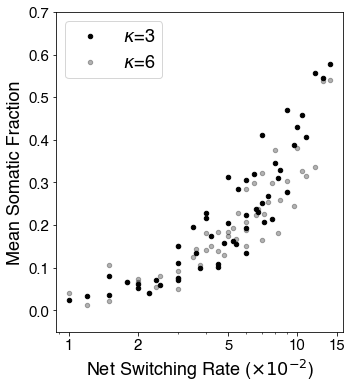

In [66]:
nsr=np.arange(2,15,1)/100
plt.rc('font',family='helvetica')
plt.figure(figsize=(5,5.5))

for d in range(4):
    dt_ratio=1.5/(1.5+(d/2))
    plt.scatter(nsr*dt_ratio,mean[2,1:,d],color='black',s=20)
    plt.scatter(nsr*dt_ratio,mean[5,1:,d],color='black',s=20,alpha=0.3)
    plt.xscale('log',base=10)
plt.xticks(ticks=[1e-2,2e-2,5e-2,1e-1,1.5e-1],labels=['1','2','5','10','15'],fontsize=15,rotation=0)
plt.yticks(fontsize=15)
plt.ylabel(r'Mean Somatic Fraction',fontsize=18)
plt.xlabel(r'Net Switching Rate ($\times 10^{-2}$)',fontsize=18)
plt.legend(['$\kappa$=3','$\kappa$=6'],fontsize=18,loc='upper left')
plt.ylim(-0.05,0.7)
plt.xlim(-0.02,0.16)
plt.tight_layout()
plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/Switching_rate_fraction_simulations.jpg',dpi=600)

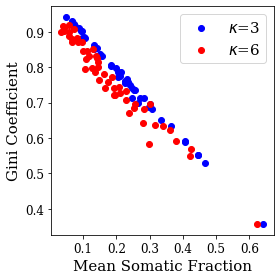

In [86]:
plt.rc('font',family='serif')
plt.figure(figsize=(4,4))
plt.scatter(mean[2,1:,0:4],gini[2,1:,0:4],color='blue')
plt.scatter(mean[4,1:,0:4],gini[4,1:,0:4],color='red')
plt.xlabel('Mean Somatic Fraction',fontsize=15)
plt.ylabel('Gini Coefficient',fontsize=15)
plt.legend(['$\kappa$=3','$\kappa$=6'],fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/mean_heterogeneity_simulations.jpg',dpi=600)

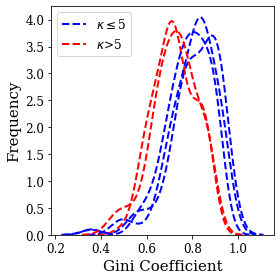

In [87]:
plt.rc('font',family='serif')
plt.figure(figsize=(4,4))
sns.distplot(gini[2,:,:],hist=False,kde_kws={'linestyle':'--','linewidth':2},color='blue')
sns.distplot(gini[6,:,:],hist=False,kde_kws={'linestyle':'--','linewidth':2},color='red')
plt.legend(['$\kappa\leq$5','$\kappa$>5'],fontsize=12,loc='upper left')
sns.distplot(gini[3,:,:],hist=False,kde_kws={'linestyle':'--','linewidth':2},color='blue')
sns.distplot(gini[4,:,:],hist=False,kde_kws={'linestyle':'--','linewidth':2},color='blue')
sns.distplot(gini[5,:,:],hist=False,kde_kws={'linestyle':'--','linewidth':2},color='red')
plt.xlabel('Gini Coefficient',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/gini_dist_simulations.jpg',dpi=600)

## Switching rates, cell proportions and breaking time

In [88]:
u=1.5
kn=3
mean=np.zeros(shape=(10,10,8))
gini=np.zeros(shape=(10,10,8))
for k in range(0,10):
    for p in range(1,11,1):
        for diff in range(8):
            frac_mean=[]
            gini_mean=[]
            for i in range(10):
                g=clust_form_and_break(int(7*u),kn,k*10,p/100,u,diff/2)
                count,ctype=count_freq(g)
                cells=pd.DataFrame({'Cluster':count,'Type':ctype})
                cells['Identity']=cells['Type'].apply(lambda x:0 if x=='yellow' else 1)

                fracs=[]
                clust_size=[]
                for m in cells['Cluster'].unique():
                    fracs.append(sum(cells.loc[cells['Cluster']==m,'Identity'])/len(cells.loc[cells['Cluster']==m,'Identity']))

                frac_arr=np.array(fracs)
                mi=frac_arr[(frac_arr<1) & (frac_arr>0)]
                frac_mean.append(np.mean(frac_arr))
                gini_mean.append(gini_coeff(frac_arr))
            mean[k,p-1,diff]=np.median(frac_mean)
            gini[k,p-1,diff]=np.median(gini_mean)

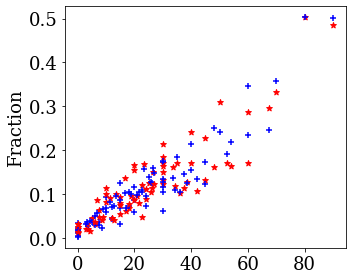

In [66]:
nsr=np.arange(0,10,1)*10
plt.rc('font',family='serif')
plt.figure(figsize=(5,4))
for d in range(8):
    dt_ratio=1.5/(1.5+(d/2))
    plt.scatter(nsr*dt_ratio,mean[0,:,d],color='red',marker='*')
    plt.scatter(nsr*dt_ratio,mean[7,:,d],color='blue',marker='+')
plt.ylabel(r'Fraction',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.tight_layout()


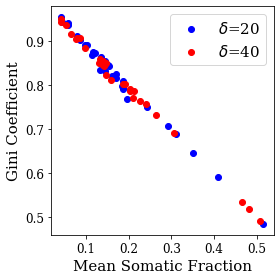

In [89]:
plt.rc('font',family='serif')
plt.figure(figsize=(4,4))
plt.scatter(mean[2,1:,0:4],gini[2,1:,0:4],color='blue')
plt.scatter(mean[4,1:,0:4],gini[4,1:,0:4],color='red')
plt.xlabel('Mean Somatic Fraction',fontsize=15)
plt.ylabel('Gini Coefficient',fontsize=15)
plt.legend(['$\delta$=20','$\delta$=40'],fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/mean_heterogeneity_delta_simulations.jpg',dpi=600)

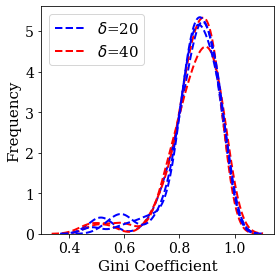

In [96]:
plt.rc('font',family='serif')
plt.figure(figsize=(4,4))
sns.distplot(gini[4,:,:],hist=False,kde_kws={'linestyle':'--','linewidth':2},color='blue')
sns.distplot(gini[5,:,:],hist=False,kde_kws={'linestyle':'--','linewidth':2},color='red')
plt.legend(['$\delta$=20','$\delta$=40'],fontsize=15)
sns.distplot(gini[6,:,:],hist=False,kde_kws={'linestyle':'--','linewidth':2},color='red')
sns.distplot(gini[2,:,:],hist=False,kde_kws={'linestyle':'--','linewidth':2},color='blue')
sns.distplot(gini[3,:,:],hist=False,kde_kws={'linestyle':'--','linewidth':2},color='blue')
plt.xlabel('Gini Coefficient',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/gini_dist_delta_simulations.jpg',dpi=600)